In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(ggplot2)
library(rjags)
library(coda)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs



# Exercise 1

Given the following un-normalized posterior distribution:

$$
g \left(\theta|x\right) \propto \frac{1}{2} e^{-\frac{\left(\theta + 3\right)^2}{2}} + \frac{1}{2} e^{-\frac{\left(\theta - 3\right)^2}{2}}
$$

- Draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm using a $Norm (0, 1)$ as random-walk candidate density and finally plot the sampled distribution
- Analyze the chain with the CODA package and plot the chain autocorrelation
- Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?


$\bold{a)}$ I use the same functions created in Exercise 2 R Lab 5 to create the MCMC in a "homemade" way:

In [2]:
# Function to sampled from:
posterior_g = function (theta) {
    return (0.5*(exp(-((theta + 3)**2)/2) + exp(-((theta - 3)**2)/2)))
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, func_change, sigma, print_accept=FALSE) {
    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = 2)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {
        # Take a guessed new theta and evaluate its probability
        guessed_theta = func_change(current_theta, sigma)
        guessed_function = func_wanted(guessed_theta)

        # Acceptance conditions
        if ((guessed_function > current_function) || ((guessed_function/current_function) > runif(1))) {
            current_theta = guessed_theta
            current_function = guessed_function
            accepted = accepted + 1
        }

        # Saving the generated samples
        samples[n, 1] = current_function
        samples[n, 2] = current_theta
    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples, 5), '\n')
    }

    return(samples)
}

# I have to use a gaussian function to generate the guessed new parameters in the MCMC
generation_function = function (x0, std) {
    return(rnorm(n = 1, mean = x0, sd = std))
}



In [3]:
# The initial parameters are:
init = 1; std = 1; burn_in = 1000
N = as.integer(1e5) + burn_in

mcmc_g = random_steps(func_wanted = posterior_g, theta_init = init, n_samples = N, func_change = generation_function, sigma = std, print_accept=TRUE)
mcmc_g = mcmc_g[,2][burn_in:N] # Selecting the sequence after the burn-in


Acceptance rate =  0.7127 


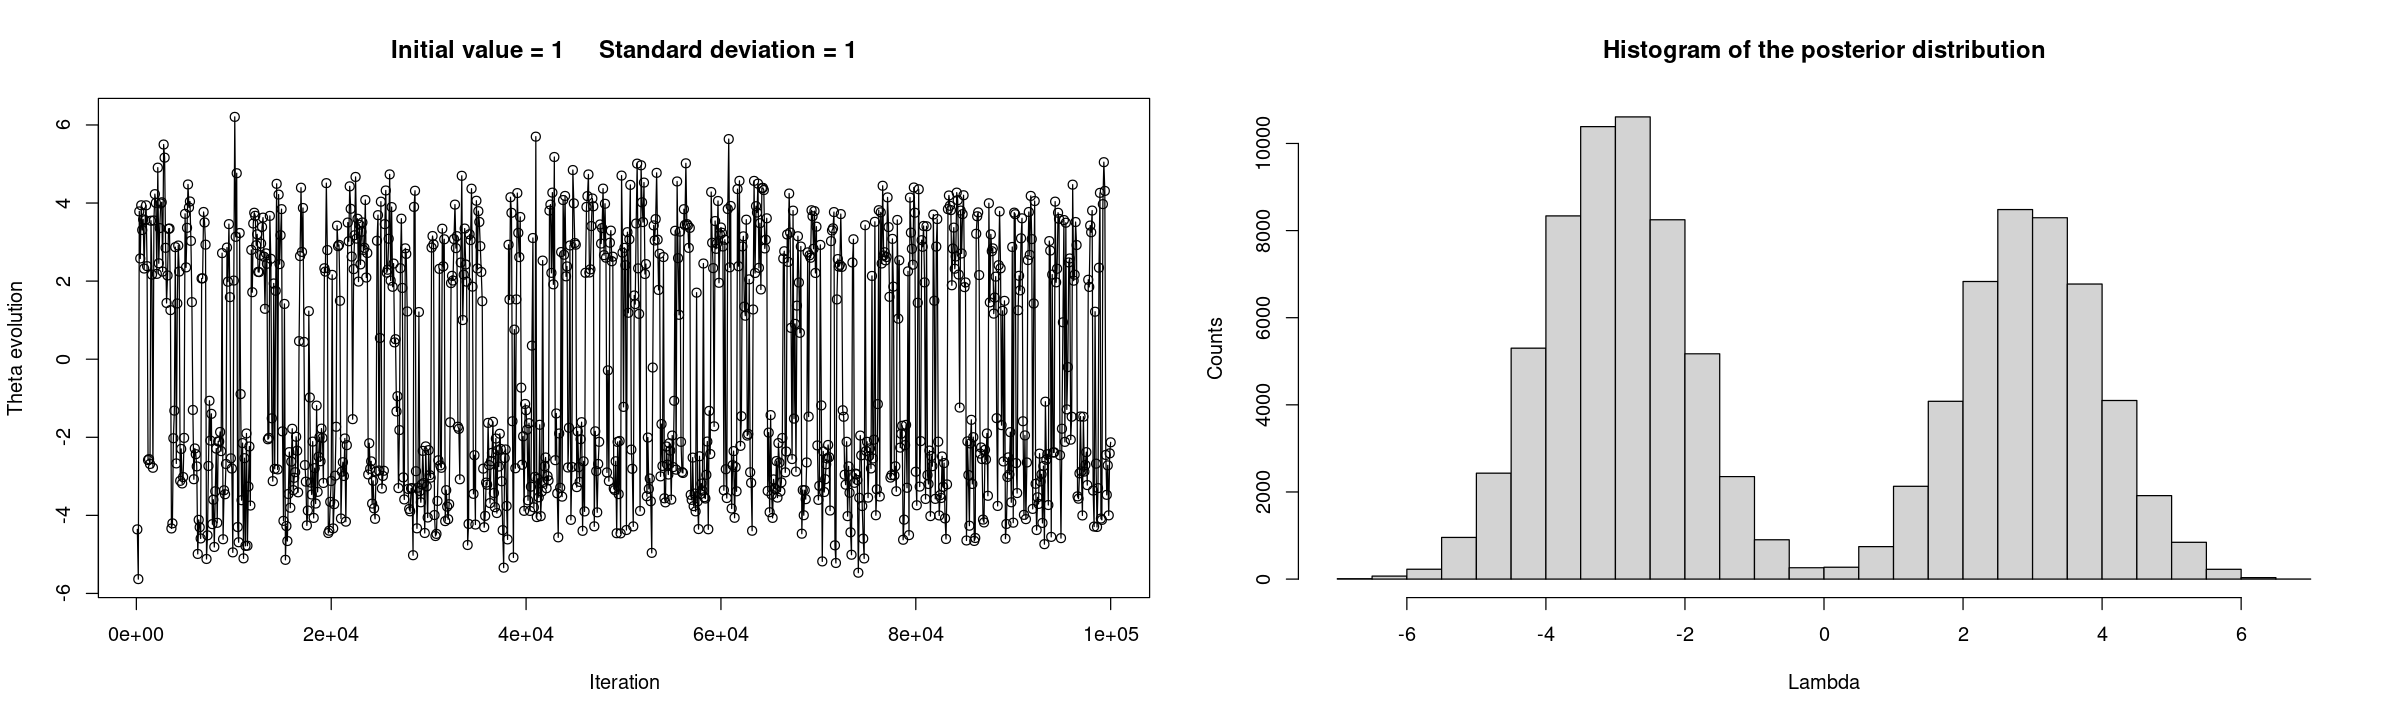

In [4]:
# Printing then the evolution of the chain and the resulting distribution
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6)

steps = 100

plot_g = mcmc_g[seq(0, length(mcmc_g), steps)] # I take a burn-in period
plot(1:length(plot_g)*steps, plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution',
        main = paste0('Initial value = ', init, '     Standard deviation = ', std))
hist(mcmc_g, breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior distribution')


$\bold{b)}$ Now I analize the chain using the CODA package:

In [5]:
# I ensure that this is now a MCMC
g_chain = as.mcmc(mcmc_g)

# Then I check the autocorrelation using CODA
lags = seq(0,1000,10)
auto_g = autocorr(g_chain, lags=lags)


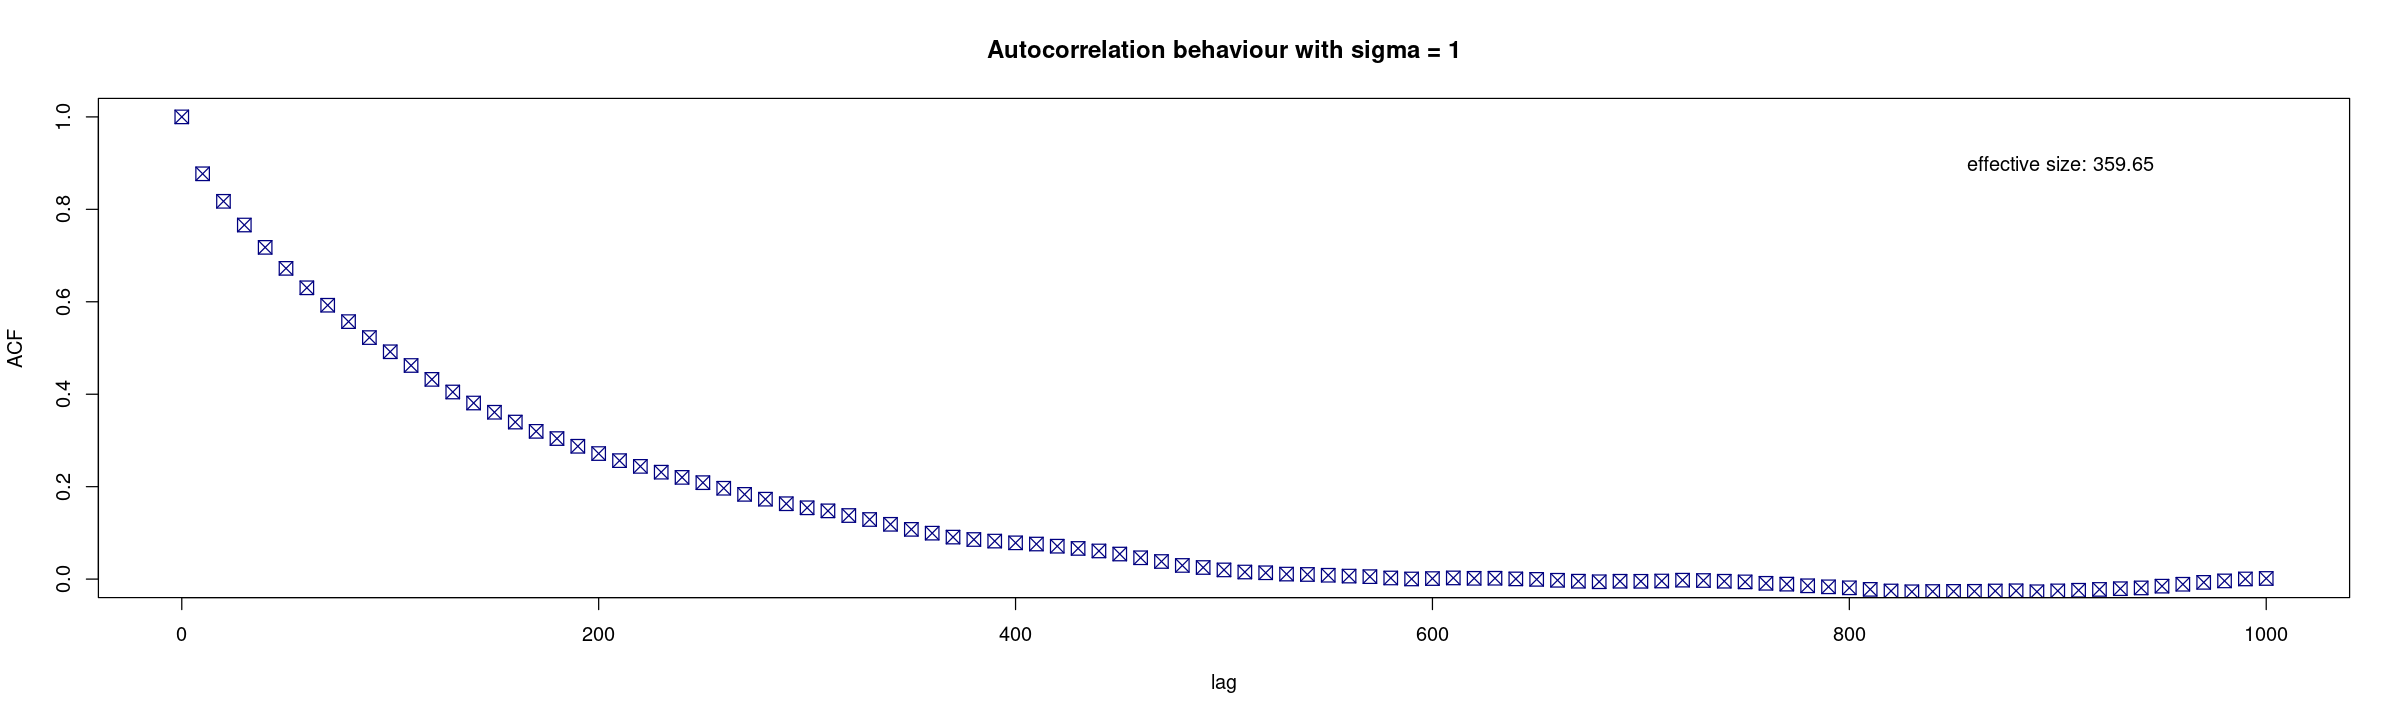

In [6]:
# And finally I plot the autocorrelation evolution:
plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", std))
text(900,0.9, sprintf (" effective size: %.2f", effectiveSize(g_chain)))

$\bold{c)}$ I loop over the dimension of the sigma in order to obtain the best parameters, using the functions defined before

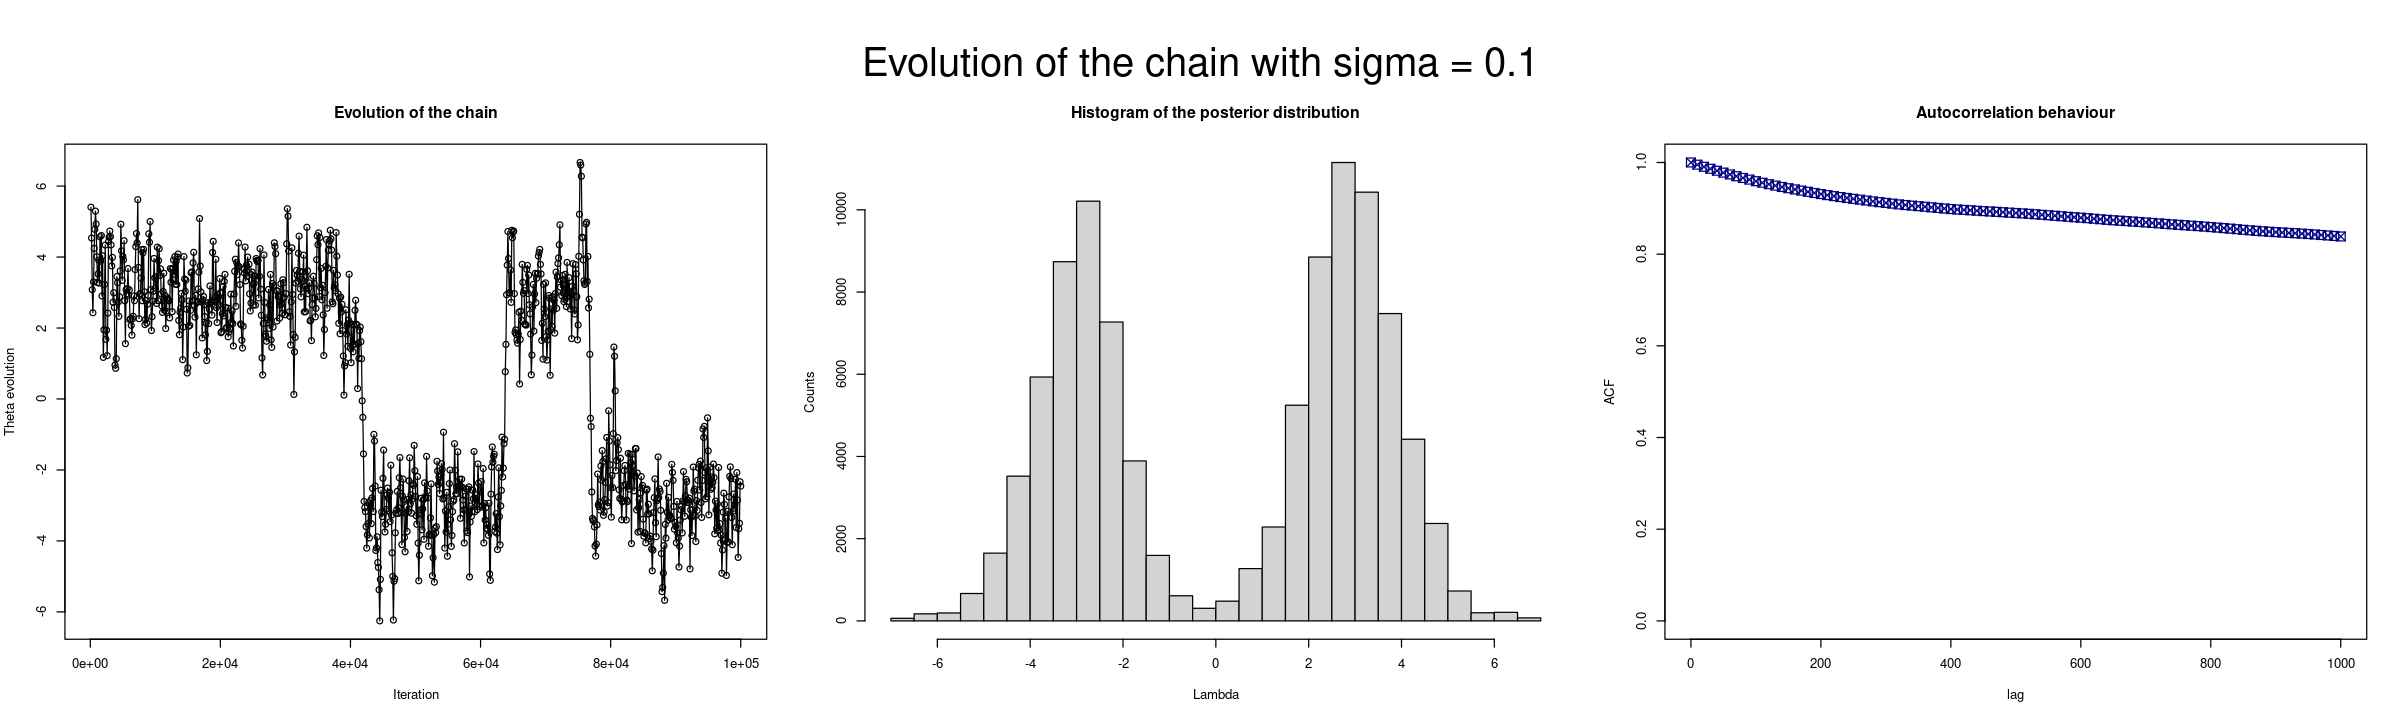

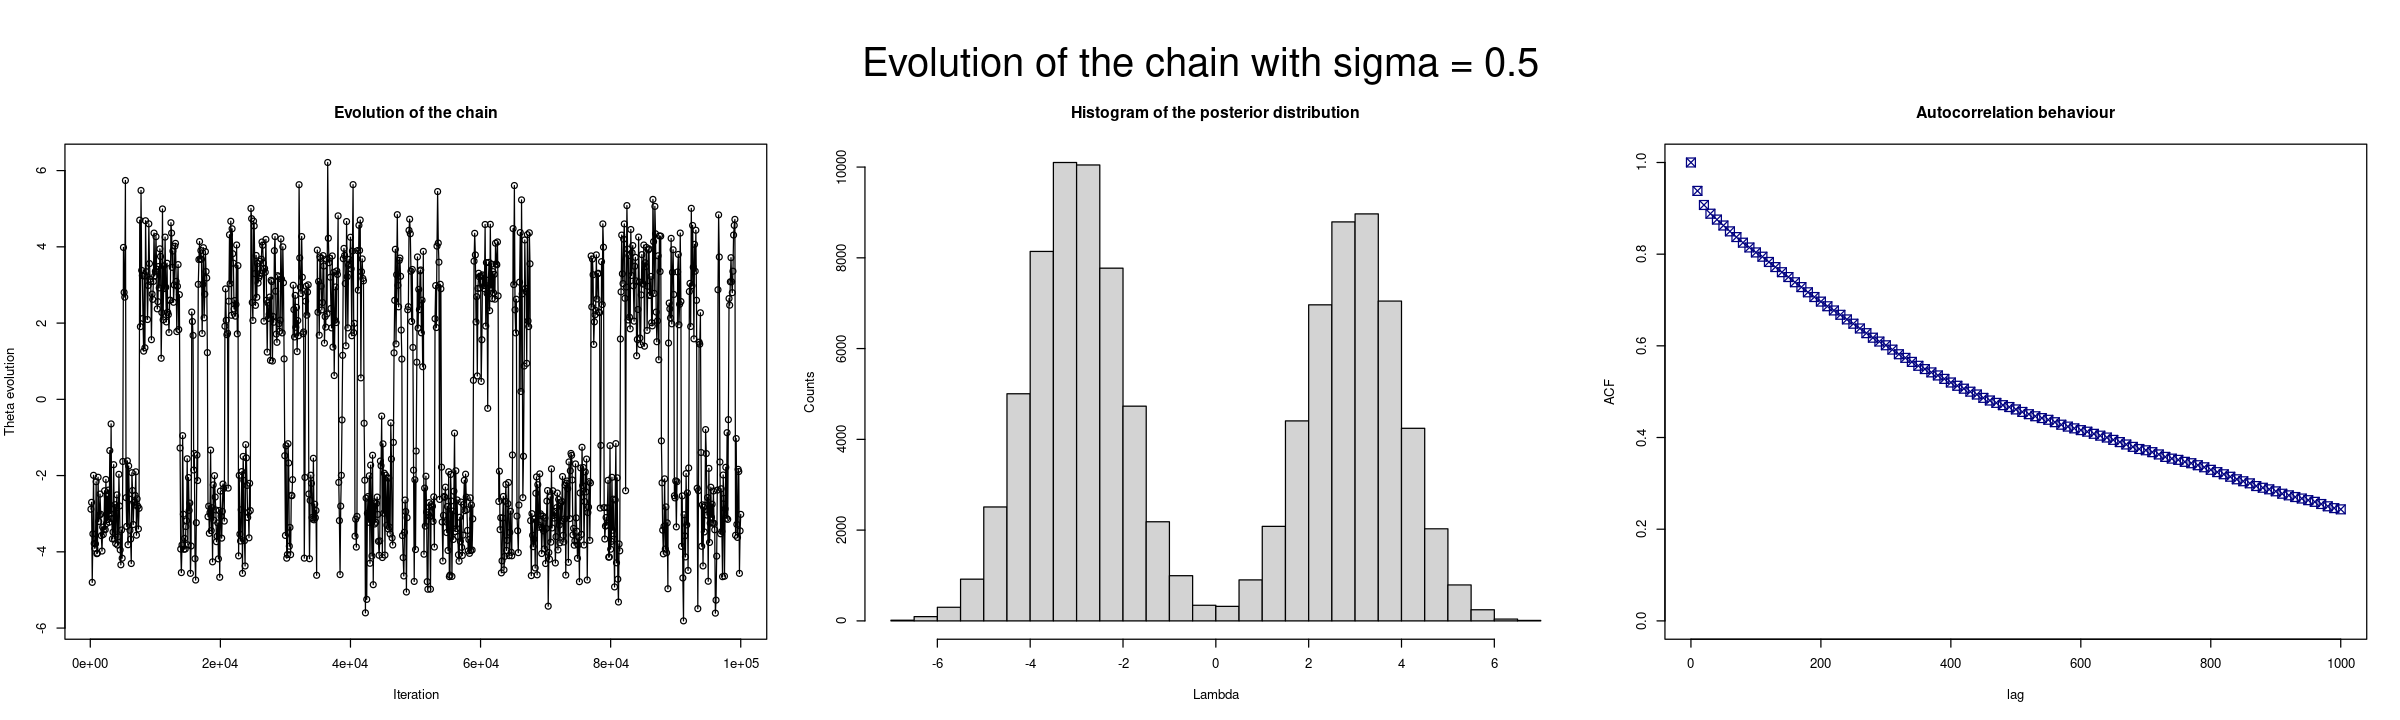

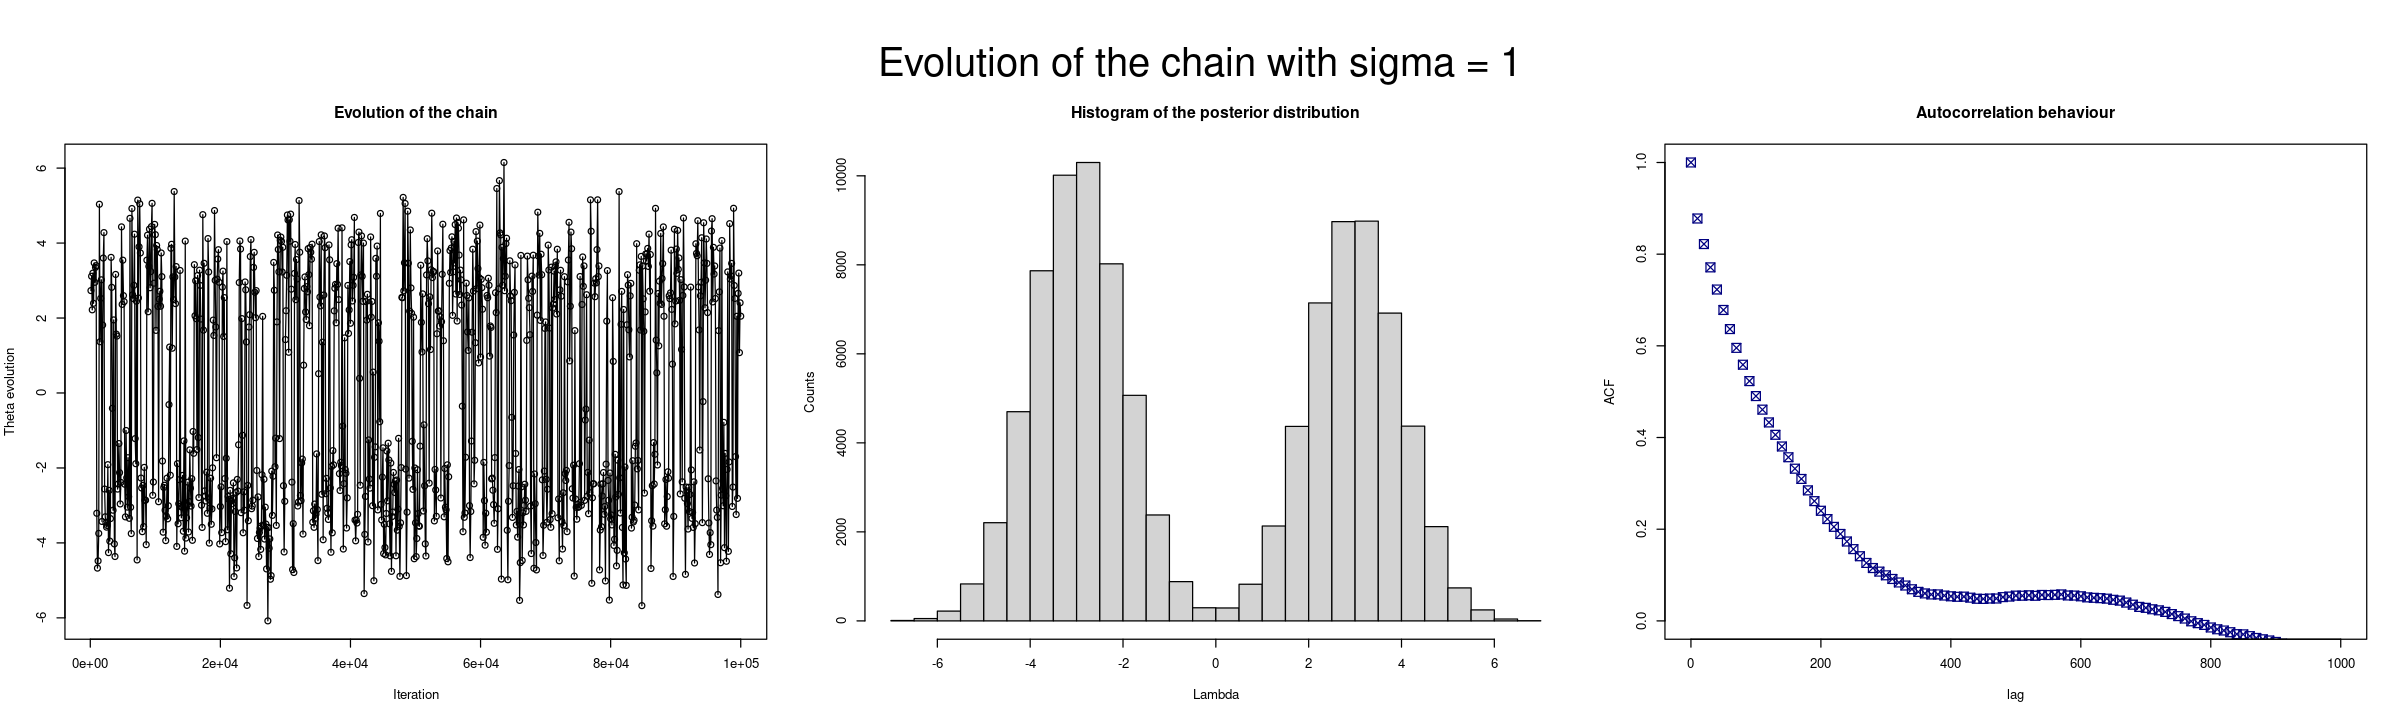

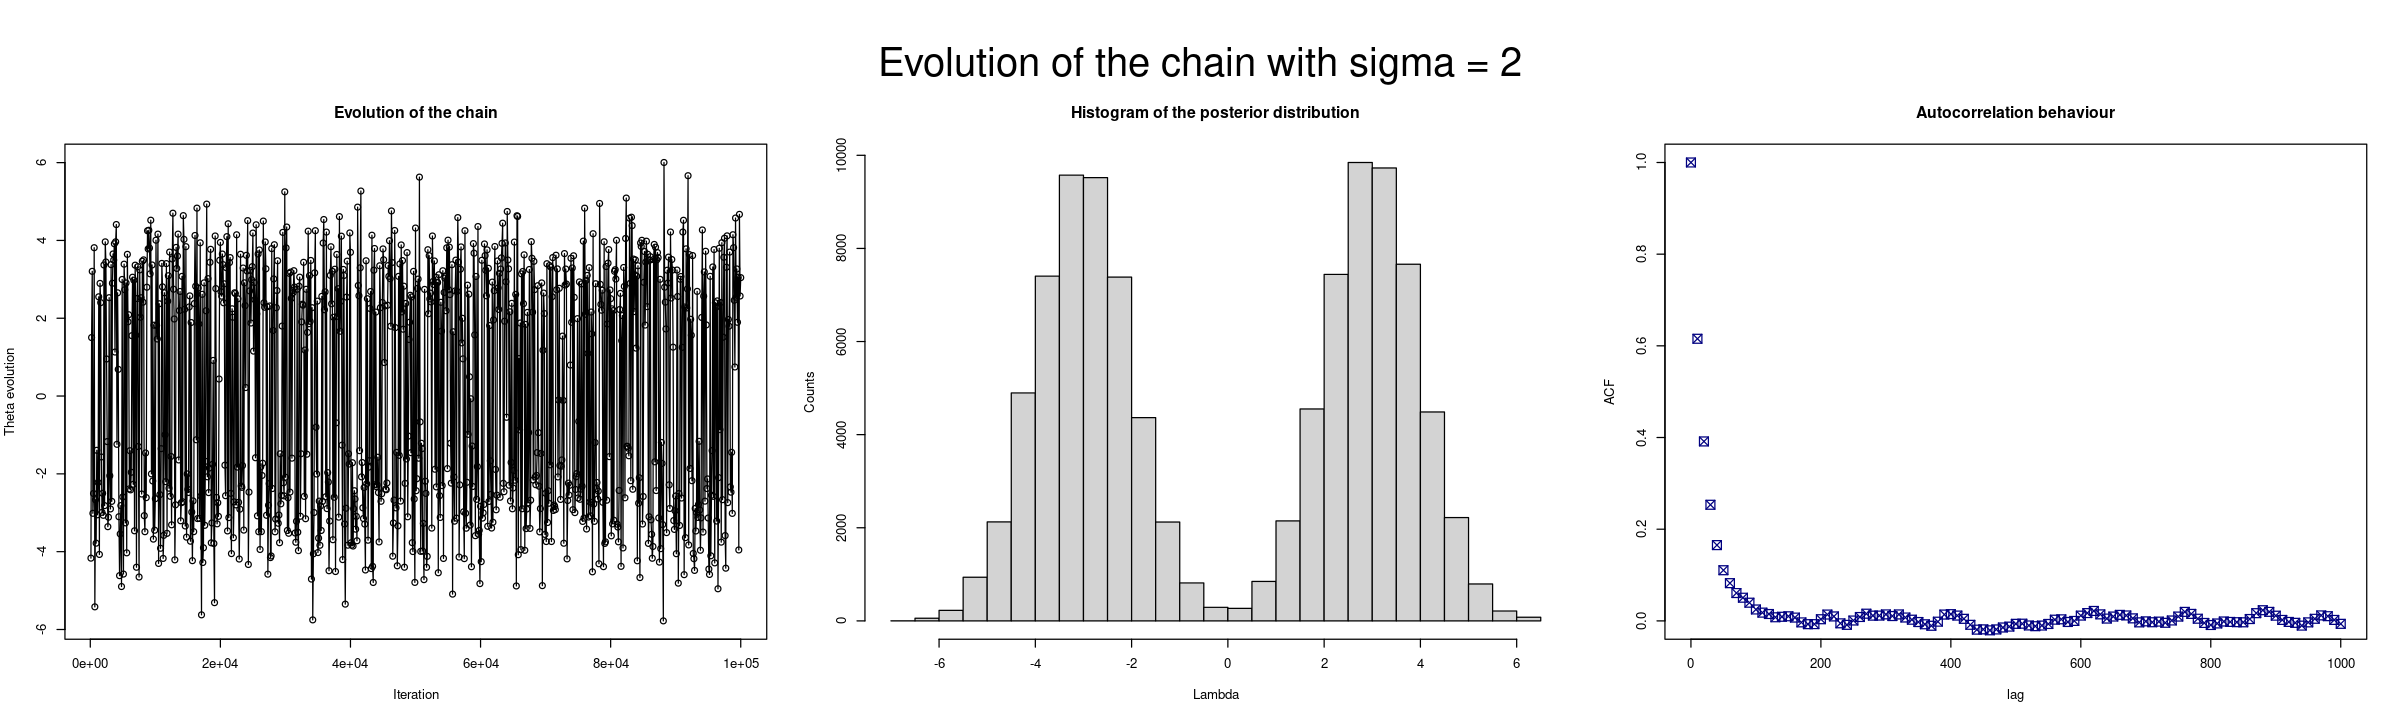

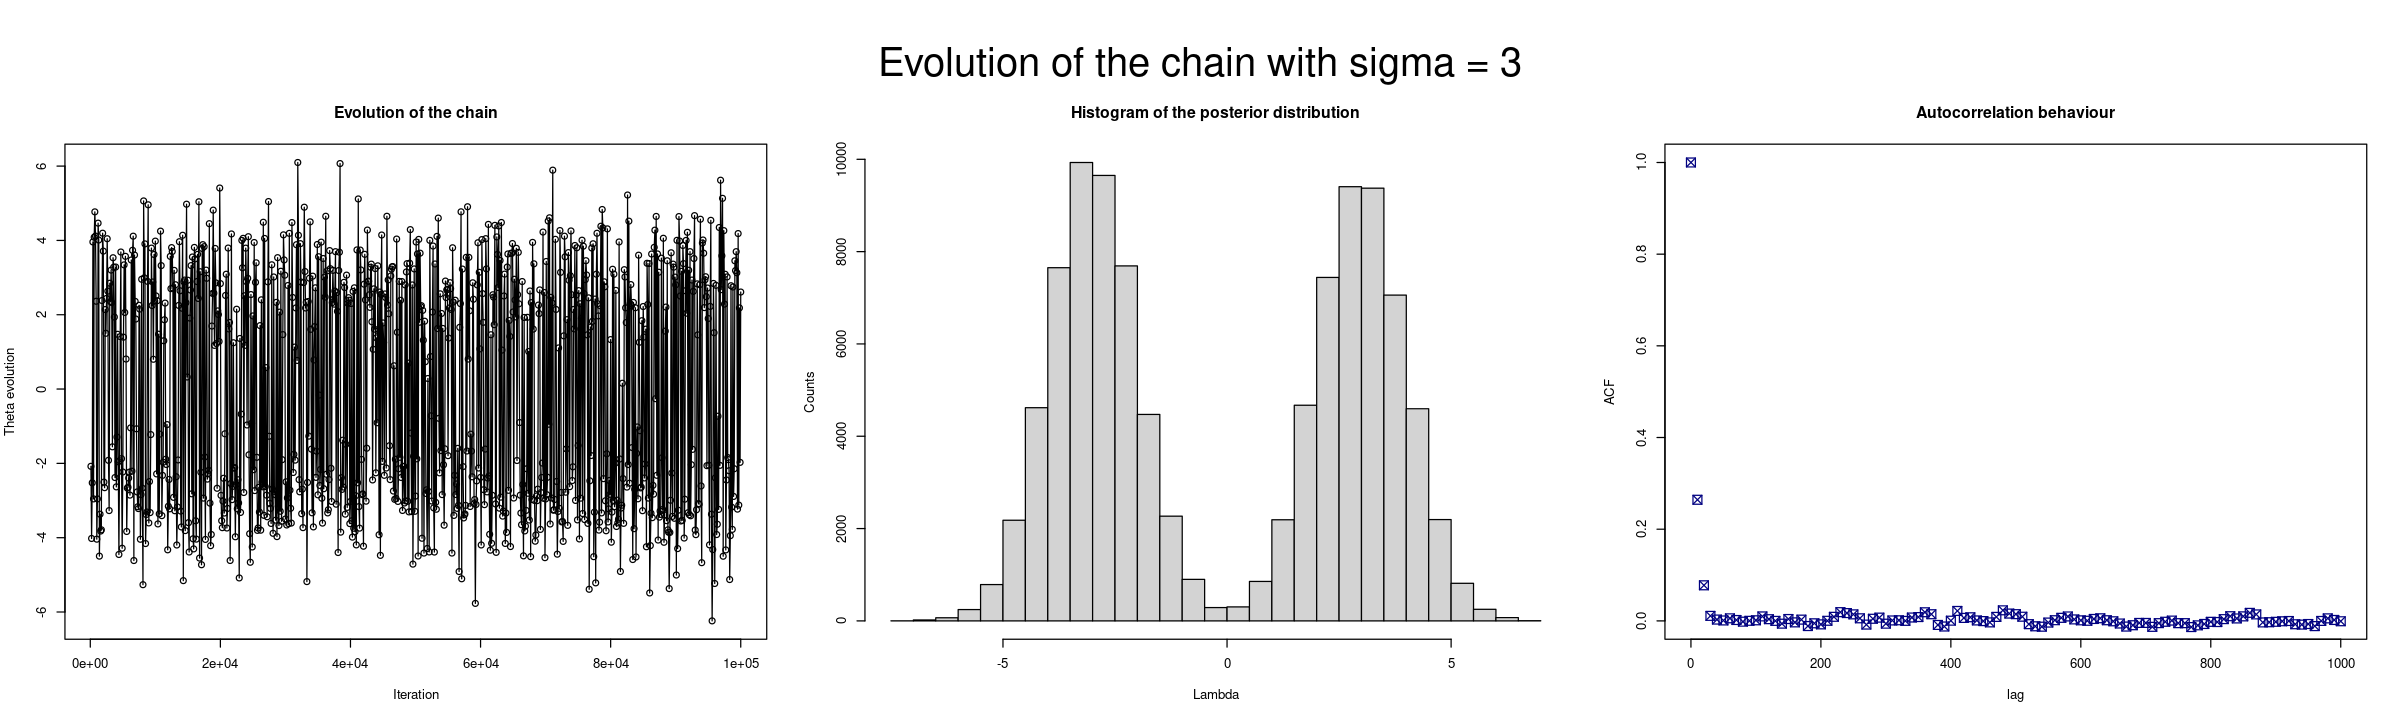

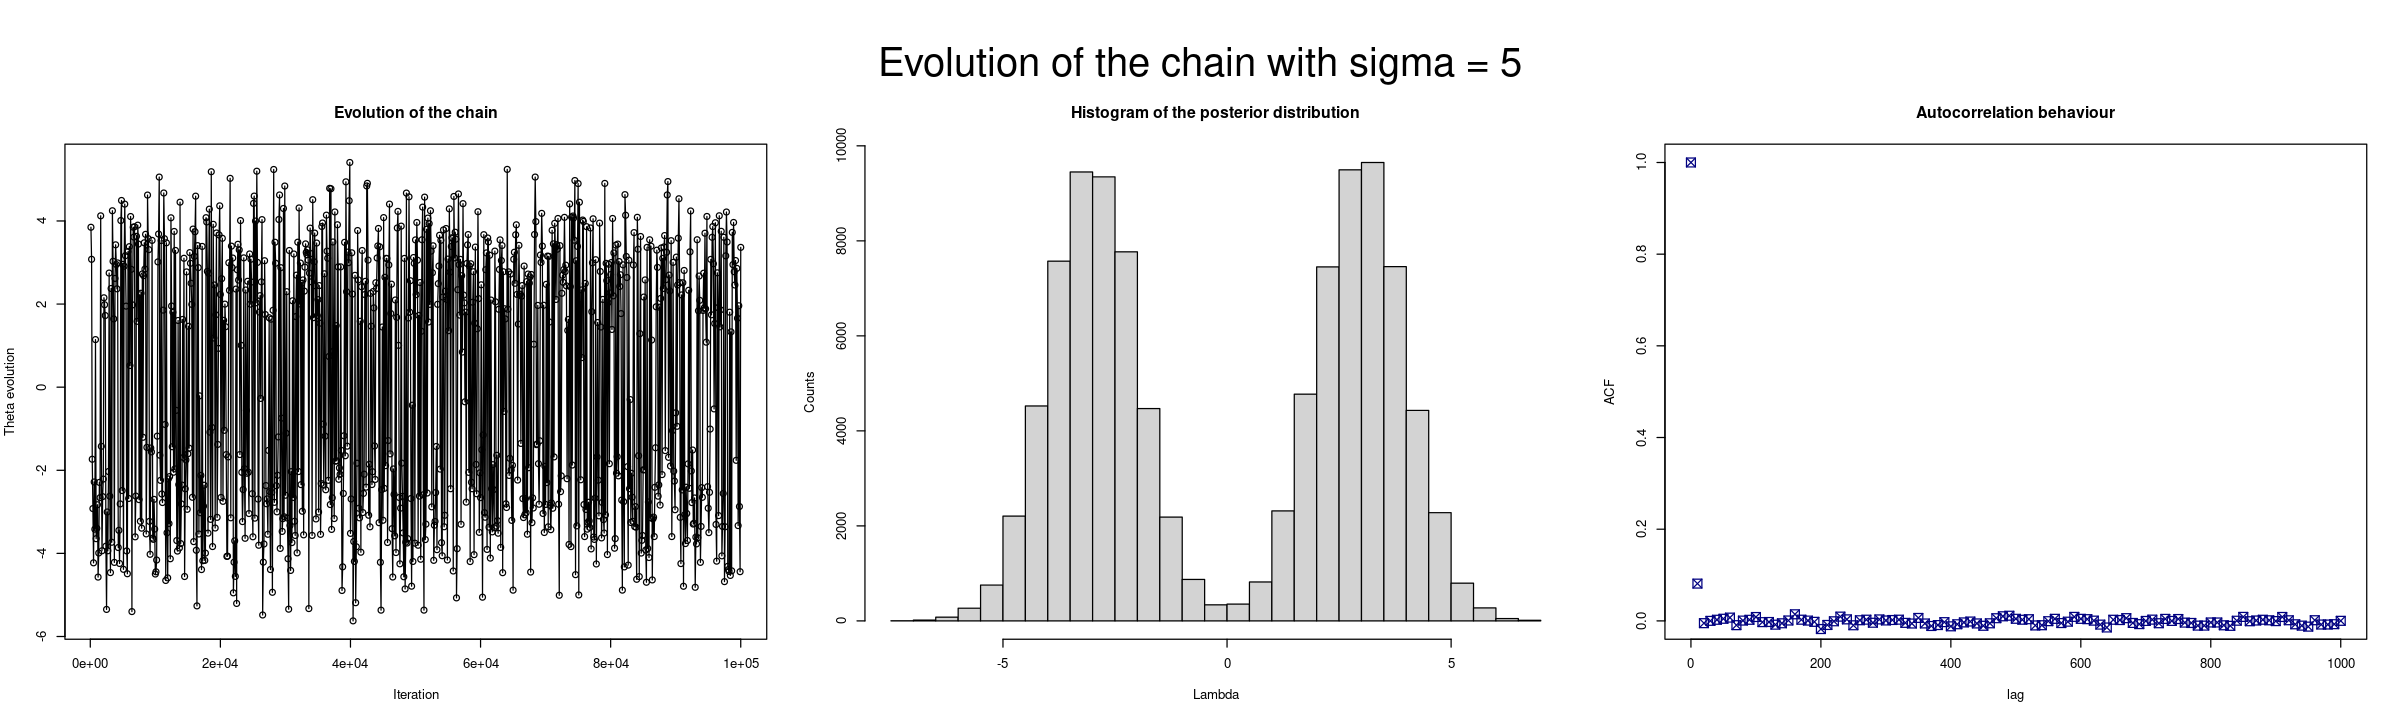

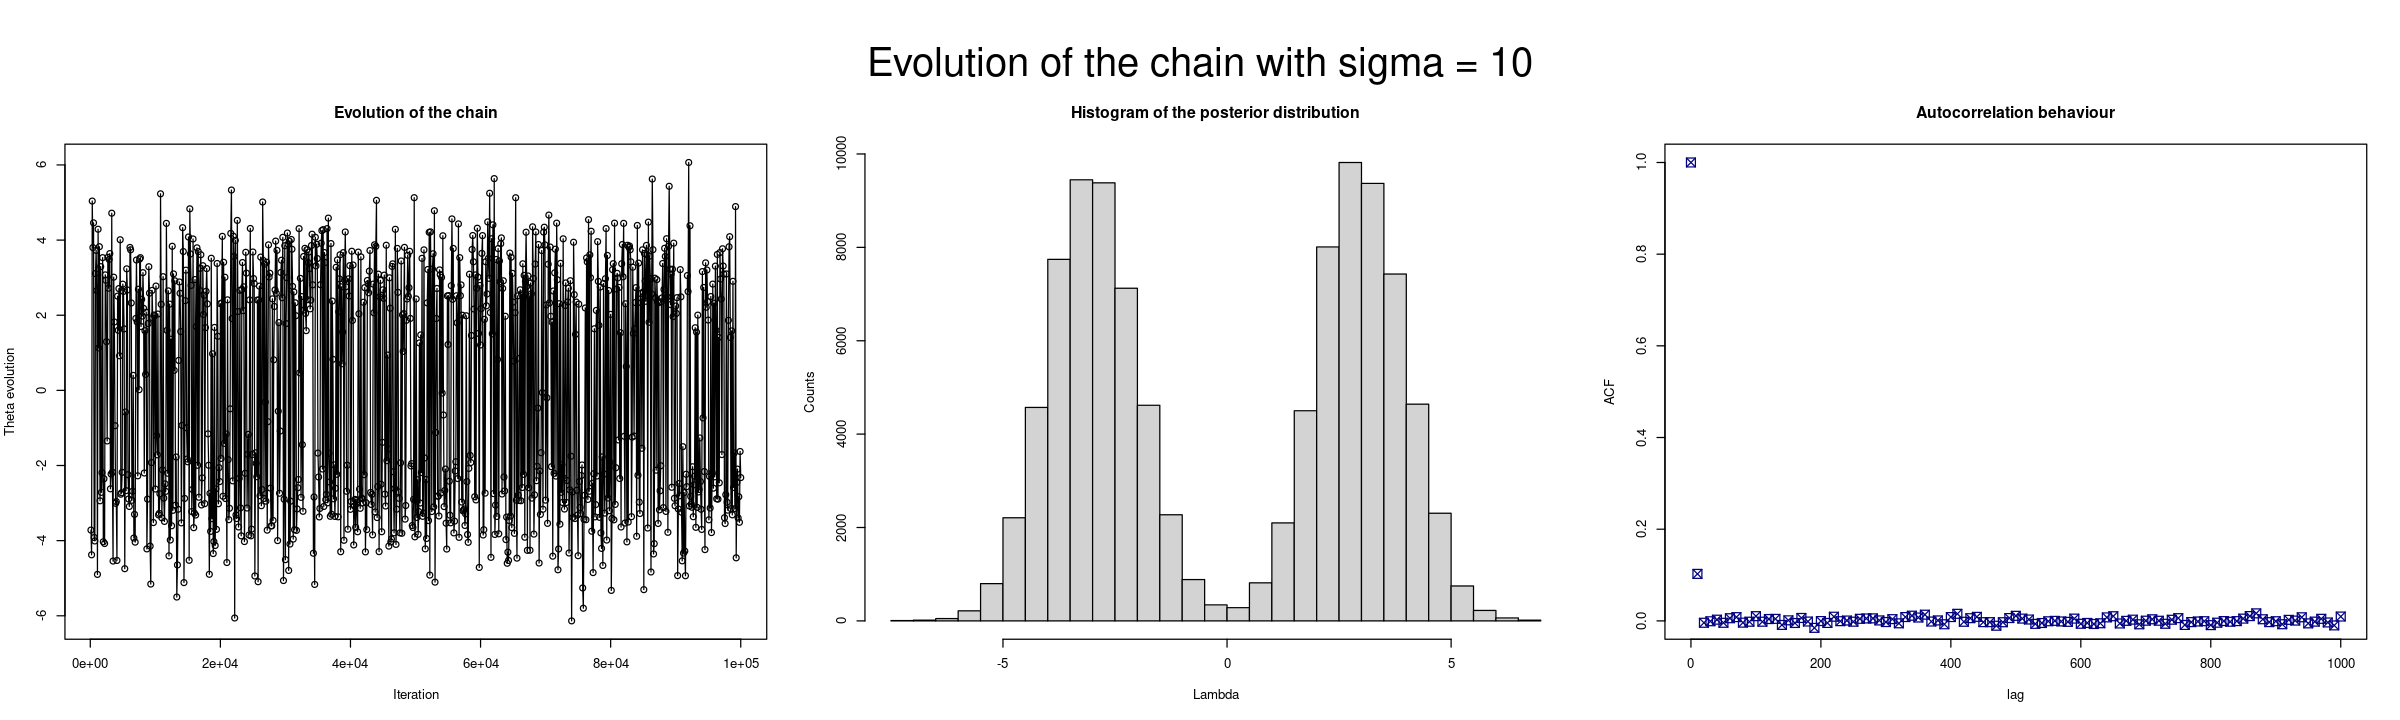

In [7]:
# Group of sigmas to loop on:
sigmas = c(0.1, 0.5, 1, 2, 3, 5, 10)

# Other parameters useful to be defined again:
init = 1; std = 1; burn_in = 1000
N = as.integer(1e5) + burn_in
lags = seq(0,1000,10)


for (std in sigmas) {
    # I recicle the functions used before:
    mcmc_g = random_steps(func_wanted = posterior_g, theta_init = init, n_samples = N, func_change = generation_function, sigma = std, print_accept=FALSE)
    mcmc_g = mcmc_g[,2][burn_in:N] # Selecting the sequence after the burn-in
    g_chain = as.mcmc(mcmc_g)
    auto_g = autocorr(g_chain, lags=lags)

    # And then I plot the results
    par(mfrow=c(1,3), oma = c(0, 0, 5, 0))
    options(repr.plot.width=20, repr.plot.height=6)
    steps = 100

    plot_g = mcmc_g[seq(0, length(mcmc_g), steps)] # I take a burn-in period
    plot(1:length(plot_g)*steps, plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', main = 'Evolution of the chain')
    hist(mcmc_g, breaks = 30, xlab = 'Lambda', ylab = 'Counts', main = 'Histogram of the posterior distribution')
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour"))

    mtext(paste("Evolution of the chain with sigma =", std) , outer = TRUE, cex = 2, font = 1)
}


From these plots we see that one obtains good results with a sigma greater than one: this means that the best parameter is $\sigma = 1$

# Exercise 2

the European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having performed a scientific evaluation of the veccines efficacy. The following vaccines are currently authorized for use in the European Union:

- Comirnaty (BioNTech and Pfizer)
- VCOVID-19 Vaccine Valneva
- Nuvaxovid (Novavax)
- Pikevax (Moderna)
- Vaxzeviria (AstraZeneca)
- Jcovden (Janssen)
- VidPrevtyn Beta (Sanofi Pasteur)
- Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.)

Analyze the initial test data reported on the EMA Web site for the following early Vaccines:

- Janssen [https://www.ema.europa.eu/en/documents/overview/covid-19-vaccine-janssen-epar-medicine-overview_en.pdf]
- Moderna [https://www.ema.europa.eu/en/documents/overview/spikevax-previously-covid-19-vaccine-moderna-epar-medicine-overview_en.pdf]
- AstraZeneca [https://www.ema.europa.eu/en/documents/overview/covid-19-vaccine-astrazeneca-epar-medicine-overview_en.pdf]
- Jcovden [https://www.ema.europa.eu/en/documents/overview/jcovden-previously-covid-19-vaccine-janssen-epar-medicine-overview_en.pdf]

Then create a Markow Chain Monte Carlo (using JAGS or stan) and evaluate the efficacy of each Vaccine. Infere the 95% credibility interval.



$\bold{a)}$ After loading the data, I can create the MCMC using JAGS (and then connecting a .bug file) for the JANSSEN vaccine:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                    Mean        SD  Naive SE Time-series SE
distribution[1] 0.017745 0.0009403 9.403e-06      9.697e-06
distribution[2] 0.006028 0.0005515 5.515e-06      5.515e-06

2. Quantiles for each variable:

                   2.5%      25%     50%      75%    97.5%
distribution[1] 0.01596 0.017109 0.01773 0.018359 0.019650
distribution[2] 0.00500 0.005645 0.00601 0.006391 0.007157



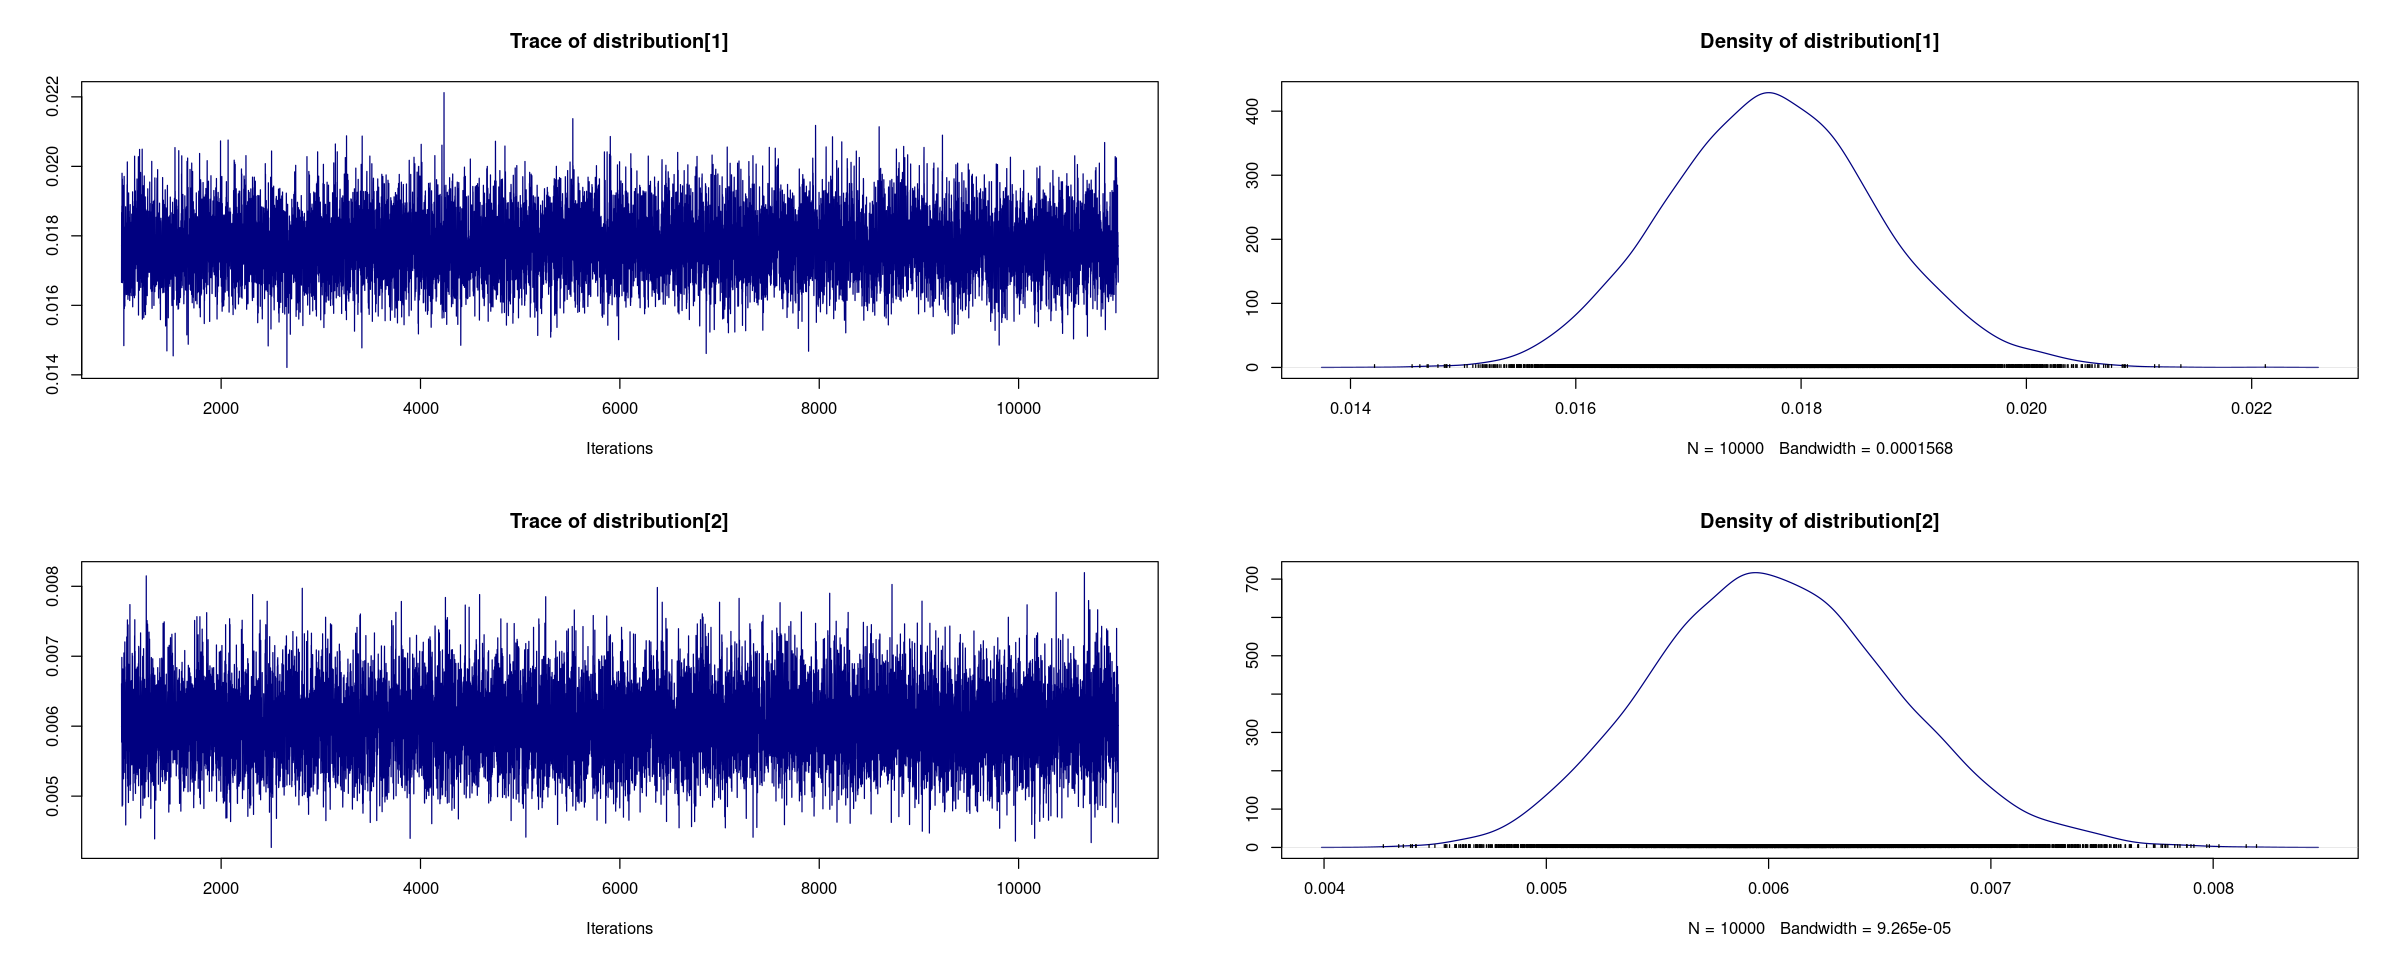

In [8]:
# I save the relevant data for the 
vaccine = 19630
placebo = 19691
vaccine_pos = 116
placebo_pos = 348

total = c(rep("V", vaccine), rep("P", placebo)) # V = vaccined
positives = c(rep("P", vaccine_pos), rep("N", vaccine - vaccine_pos), rep("P", placebo_pos), rep("N", placebo - placebo_pos)) # 1 = positive to COVID

# Then I can create the samples list containing these data
data = list(
    total = as.integer(factor(total)),
    length_total = length(unique(total)),
    positives = ifelse(positives == "N", 0, 1),
    length_positives = length(positives)
)

# And then I can use the .bug file to create the posterior
jags_model = jags.model('ex02_les06.bug', data)
update(jags_model, 1000)

# Creation of the rjags chain
janssen_chain = coda.samples(jags_model, c("distribution"), n.iter=10000)
print(summary(janssen_chain))

# And in the end I create a plot for clarity of the results
options(repr.plot.width=20, repr.plot.height=8)
plot(janssen_chain, col="navy")


In [9]:
# For the 95% credibility interval and the efficacy I load both the chain and the result file
chain_df = as.data.frame( as.mcmc(janssen_chain) )
results = summary(janssen_chain)

# 95% CI:
cat("The Credibility interval is [", round(results$quantiles[1,1], 4), ",", round(results$quantiles[1,5], 4),"] for the Vaccined distribution\n")
cat("The Credibility interval is [", round(results$quantiles[2,1], 5), ",", round(results$quantiles[2,5], 5),"] for the Placeboed distribution\n")

# For plotting reasons I retrieve mean, variance and standard deviation of the chain
chain_means = sapply(chain_df, mean)
chain_vars = sapply(chain_df, var)
chain_stds = sqrt(chain_vars)

# Efficacy
cat("The efficacy of the test is ", round((1 - chain_means[2]/chain_means[1])*100, 2), "%")



The Credibility interval is [ 0.016 , 0.0197 ] for the Vaccined distribution
The Credibility interval is [ 0.005 , 0.00716 ] for the Placeboed distribution
The efficacy of the test is  66.03 %

Here I see that I obtain the same results given by the EMA autorities

$\bold{b)}$ Now I perform the same analysis for the MODERNA vaccine, based on the extracted informations "11 out of 14,134 vaccinated people got COVID-19 with symptoms. 185 out of 14,073 people who received dummy injections got COVID-19 with symptoms"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                     Mean        SD  Naive SE Time-series SE
distribution[1] 0.0132655 0.0009682 9.682e-06      9.682e-06
distribution[2] 0.0009886 0.0002634 2.634e-06      2.634e-06

2. Quantiles for each variable:

                     2.5%       25%       50%     75%   97.5%
distribution[1] 0.0114518 0.0126083 0.0132472 0.01390 0.01525
distribution[2] 0.0005414 0.0008004 0.0009635 0.00115 0.00158



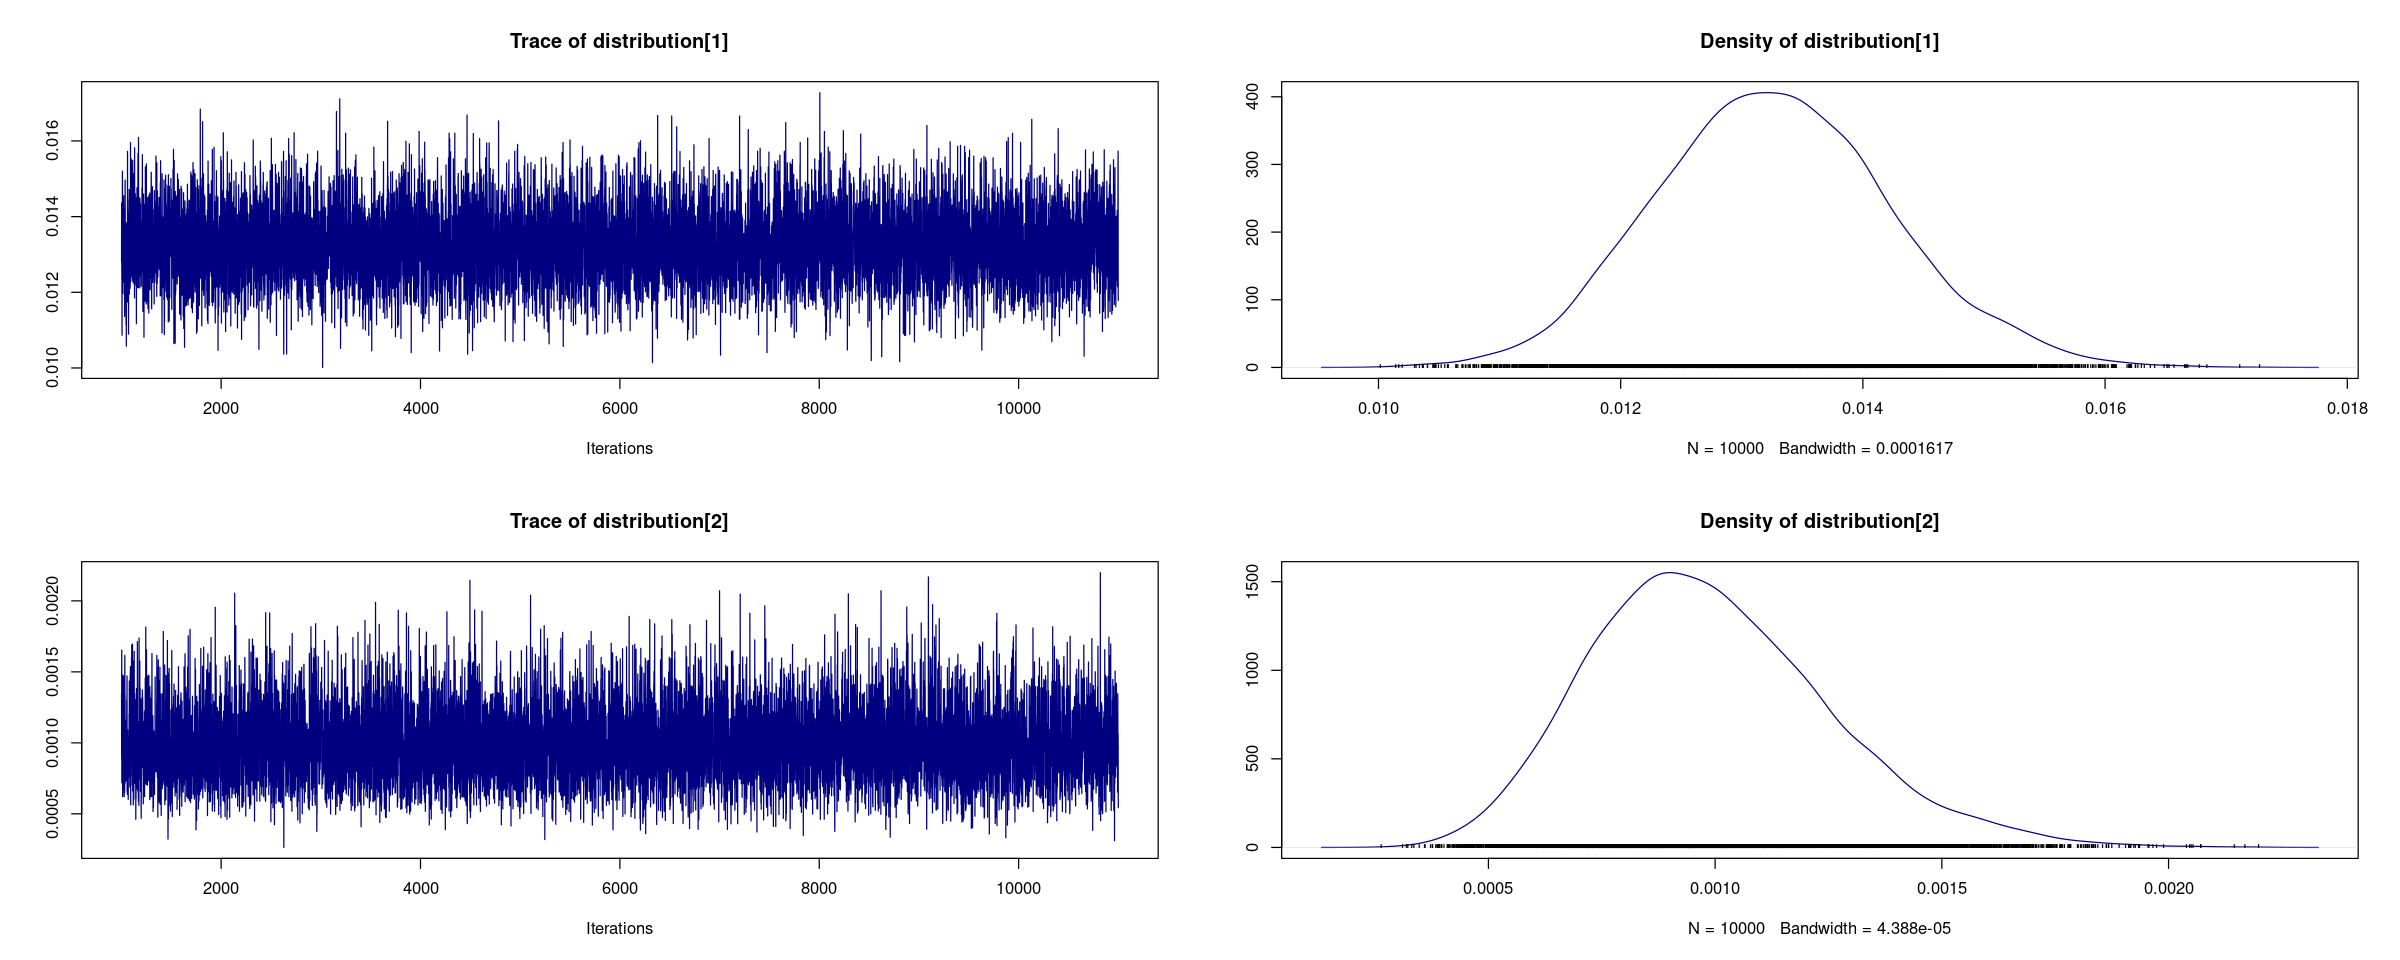

In [10]:
# I save the relevant data for the 
vaccine = 14134
placebo = 14073
vaccine_pos = 11
placebo_pos = 185


total = c(rep("V", vaccine), rep("P", placebo)) # V = vaccined
positives = c(rep("P", vaccine_pos), rep("N", vaccine - vaccine_pos), rep("P", placebo_pos), rep("N", placebo - placebo_pos)) # 1 = positive to COVID

# Then I can create the samples list containing these data
data = list(
    total = as.integer(factor(total)),
    length_total = length(unique(total)),
    positives = ifelse(positives == "N", 0, 1),
    length_positives = length(positives)
)

# And then I can use the .bug file to create the posterior
jags_model = jags.model('ex02_les06.bug', data)
update(jags_model, 1000)

# Creation of the rjags chain
moderna_chain = coda.samples(jags_model, c("distribution"), n.iter=10000)
print(summary(moderna_chain))

# And in the end I create a plot for clarity of the results
options(repr.plot.width=20, repr.plot.height=8)
plot(moderna_chain, col="navy")


In [11]:
# For the 95% credibility interval and the efficacy I load both the chain and the result file
chain_df = as.data.frame( as.mcmc(moderna_chain) )
results = summary(moderna_chain)

# 95% CI:
cat("The Credibility interval is [", round(results$quantiles[1,1], 4), ",", round(results$quantiles[1,5], 4),"] for the Vaccined distribution\n")
cat("The Credibility interval is [", round(results$quantiles[2,1], 5), ",", round(results$quantiles[2,5], 5),"] for the Placeboed distribution\n")

# For plotting reasons I retrieve mean, variance and standard deviation of the chain
chain_means = sapply(chain_df, mean)
chain_vars = sapply(chain_df, var)
chain_stds = sqrt(chain_vars)

# Efficacy
cat("The efficacy of the test is ", round((1 - chain_means[2]/chain_means[1])*100, 2), "%")



The Credibility interval is [ 0.0115 , 0.0152 ] for the Vaccined distribution
The Credibility interval is [ 0.00054 , 0.00158 ] for the Placeboed distribution
The efficacy of the test is  92.55 %

These results are in accordance with the one found by EMA, that I quote: "This means that the vaccine demonstrated a 94.1% efficacy in the trial. The trial also showed 90.9% efficacy in participants at risk of severe COVID-19, including those with chronic lung disease, heart disease, obesity, liver disease, diabetes or HIV infection."

$\bold{c)}$ I do then the same for AstraZaneca vaccine:


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 26212
   Unobserved stochastic nodes: 2
   Total graph size: 52430

Initializing model


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                    Mean        SD  Naive SE Time-series SE
distribution[1] 0.015339 0.0013116 1.312e-05      1.312e-05
distribution[2] 0.004283 0.0004914 4.914e-06      4.914e-06

2. Quantiles for each variable:

                    2.5%      25%      50%      75%    97.5%
distribution[1] 0.012883 0.014444 0.015282 0.016186 0.018067
distribution[2] 0.003378 0.003935 0.004268 0.004603 0.005308



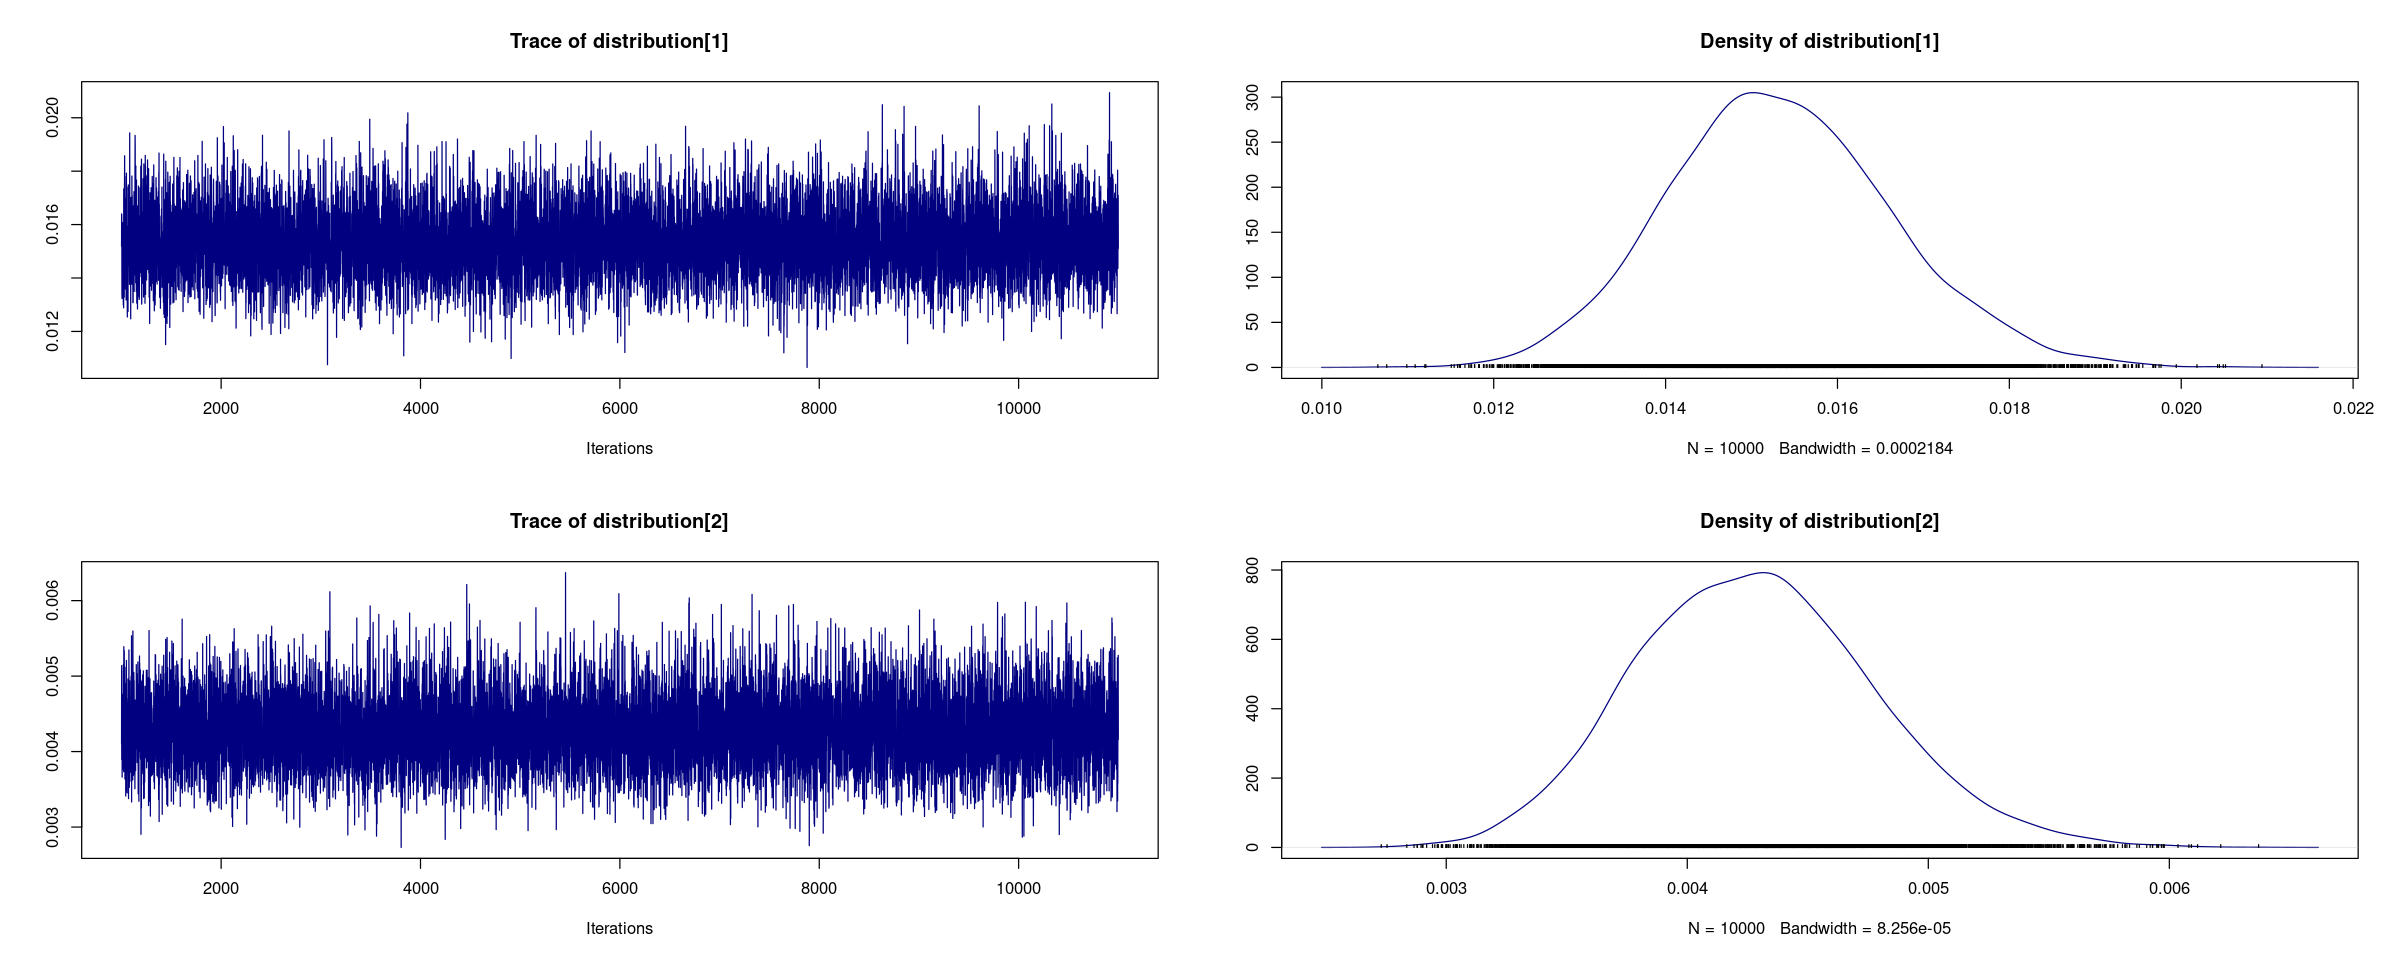

In [12]:
# I save the relevant data for the 
vaccine = 17662
placebo = 8550
vaccine_pos = 73
placebo_pos = 130


total = c(rep("V", vaccine), rep("P", placebo)) # V = vaccined
positives = c(rep("P", vaccine_pos), rep("N", vaccine - vaccine_pos), rep("P", placebo_pos), rep("N", placebo - placebo_pos)) # 1 = positive to COVID

# Then I can create the samples list containing these data
data = list(
    total = as.integer(factor(total)),
    length_total = length(unique(total)),
    positives = ifelse(positives == "N", 0, 1),
    length_positives = length(positives)
)

# And then I can use the .bug file to create the posterior
jags_model = jags.model('ex02_les06.bug', data)
update(jags_model, 1000)

# Creation of the rjags chain
astraz_chain = coda.samples(jags_model, c("distribution"), n.iter=10000)
print(summary(astraz_chain))

# And in the end I create a plot for clarity of the results
options(repr.plot.width=20, repr.plot.height=8)
plot(astraz_chain, col="navy")


In [13]:
# For the 95% credibility interval and the efficacy I load both the chain and the result file
chain_df = as.data.frame( as.mcmc(astraz_chain) )
results = summary(astraz_chain)

# 95% CI:
cat("The Credibility interval is [", round(results$quantiles[1,1], 4), ",", round(results$quantiles[1,5], 4),"] for the Vaccined distribution\n")
cat("The Credibility interval is [", round(results$quantiles[2,1], 5), ",", round(results$quantiles[2,5], 5),"] for the Placeboed distribution\n")

# For plotting reasons I retrieve mean, variance and standard deviation of the chain
chain_means = sapply(chain_df, mean)
chain_vars = sapply(chain_df, var)
chain_stds = sqrt(chain_vars)

# Efficacy
cat("The efficacy of the test is ", round((1 - chain_means[2]/chain_means[1])*100, 2), "%")



The Credibility interval is [ 0.0129 , 0.0181 ] for the Vaccined distribution
The Credibility interval is [ 0.00338 , 0.00531 ] for the Placeboed distribution
The efficacy of the test is  72.08 %

$\bold{d)}$ Finally I find that Janssen and Jcovden do have the same database in this moment

# Exercise 3

According to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available [https://ourworldindata.org/covid-vaccinations]

The European Centre for Disease Prevention and Control published a downloadable file [https://github.com/owid/covid-19-data/tree/master/public/data] containing information on COVID-19 vaccination in the EU/EEA.

Analyze the data and produce the following plots:
- number of vaccinated people (cumulative, daily and week average)
- number of confirmed deaths by COVID-19, both cumulative and weekly average


$\bold{a)}$ The dataset is the same, thus I load it in R as a dataframe and then I can count the number of vaccinated people:

In [14]:
# Load the csv dataset for global vaccination:
filein = "data/owid-covid-data.csv"
data = read.csv(filein, header = T)

# Print the tail of the df
tail(data, 10)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
313257,ZWE,Africa,Zimbabwe,2023-05-15,264848,7,10.286,5690,0,0.286,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313258,ZWE,Africa,Zimbabwe,2023-05-16,264848,0,9.429,5690,0,0.286,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313259,ZWE,Africa,Zimbabwe,2023-05-17,264848,0,8.143,5690,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313260,ZWE,Africa,Zimbabwe,2023-05-18,264848,0,7.000,5690,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313261,ZWE,Africa,Zimbabwe,2023-05-19,264848,0,4.571,5690,0,0.143,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313262,ZWE,Africa,Zimbabwe,2023-05-20,264848,0,3.857,5690,0,0.000,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313263,ZWE,Africa,Zimbabwe,2023-05-21,264848,0,1.000,5690,0,0.000,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313264,ZWE,Africa,Zimbabwe,2023-05-22,264848,0,0.000,5690,0,0.000,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA
313265,ZWE,Africa,Zimbabwe,2023-05-23,264848,0,0.000,5690,0,0.000,⋯,30.7,36.791,1.7,61.49,0.571,16320539,NA,NA,NA,NA


Looking at the loaded data, I see that there is a location for the world, therefore I use that: ohterwise I could have grouped by the date and summed over all the other columns

In [15]:
# I then select only the required data (using both "iso_code" or "location" as key) # world_data = data[data$iso_code == "OWID_WRL", ]
world_data = data[data$location == "World", ]

library(lubridate)

# Then I get rid of the NA data:
world_data = world_data[!is.na(world_data$total_cases), ]

# And then I convert the date into a real date format and add a column in order to get the number of the week and the year (for further analysis)
world_data$date = as.Date.character((world_data$date), "%Y-%m-%d")
world_data$week = week(world_data$date)
world_data$year = as.numeric(format(world_data$date, "%Y"))

tail(world_data, 10)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,week,year
,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
309538,OWID_WRL,,World,2023-05-15,766543531,123350,77506.00,6933813,263,600.143,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309539,OWID_WRL,,World,2023-05-16,766583982,40451,75205.14,6934075,262,601.714,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309540,OWID_WRL,,World,2023-05-17,766628655,44673,75054.00,6934220,145,588.857,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309541,OWID_WRL,,World,2023-05-18,766667443,38788,74006.43,6934391,171,584.143,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309542,OWID_WRL,,World,2023-05-19,766724863,57420,75716.86,6934779,388,609.286,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309543,OWID_WRL,,World,2023-05-20,766758430,33567,73868.71,6934951,172,604.714,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,20,2023
309544,OWID_WRL,,World,2023-05-21,766844213,85783,60576.00,6935527,576,282.429,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,21,2023
309545,OWID_WRL,,World,2023-05-22,766889982,45769,49493.00,6935837,310,289.143,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,21,2023
309546,OWID_WRL,,World,2023-05-23,766894311,4329,44332.71,6935876,39,257.286,⋯,2.705,72.58,0.737,7975105024,NA,NA,NA,NA,21,2023


Then I can divide the three required cathegories

In [16]:
# I take the cumulative number of vaccined people after removing NAs
if (length(world_data[is.na(world_data$people_vaccinated), ]$people_vaccinated) > 0) {
    world_data[is.na(world_data$people_vaccinated), ]$people_vaccinated = 0}
cumulative_vaccines = world_data$people_vaccinated

# Then the daily vaccined people are similarly retrieved
if (length(world_data[is.na(world_data$new_vaccinations), ]$new_vaccinations) > 0) {
    world_data[is.na(world_data$new_vaccinations), ]$new_vaccinations = 0}
daily_vaccines = world_data$new_vaccinations

# For the weekly average I have to add a column
weekly_vaccines = world_data %>% group_by(week, year) %>% summarise(total_per_week = mean(new_vaccinations))
weekly_vaccines$cumulative_week = as.Date(paste(weekly_vaccines$week, weekly_vaccines$year, 'Sun'), '%U %Y %a')
weekly_vaccines = weekly_vaccines[order(weekly_vaccines$cumulative_week),]


`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 368 in year 2020 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 366 in year 2021 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 365 in year 2022 is invalid”


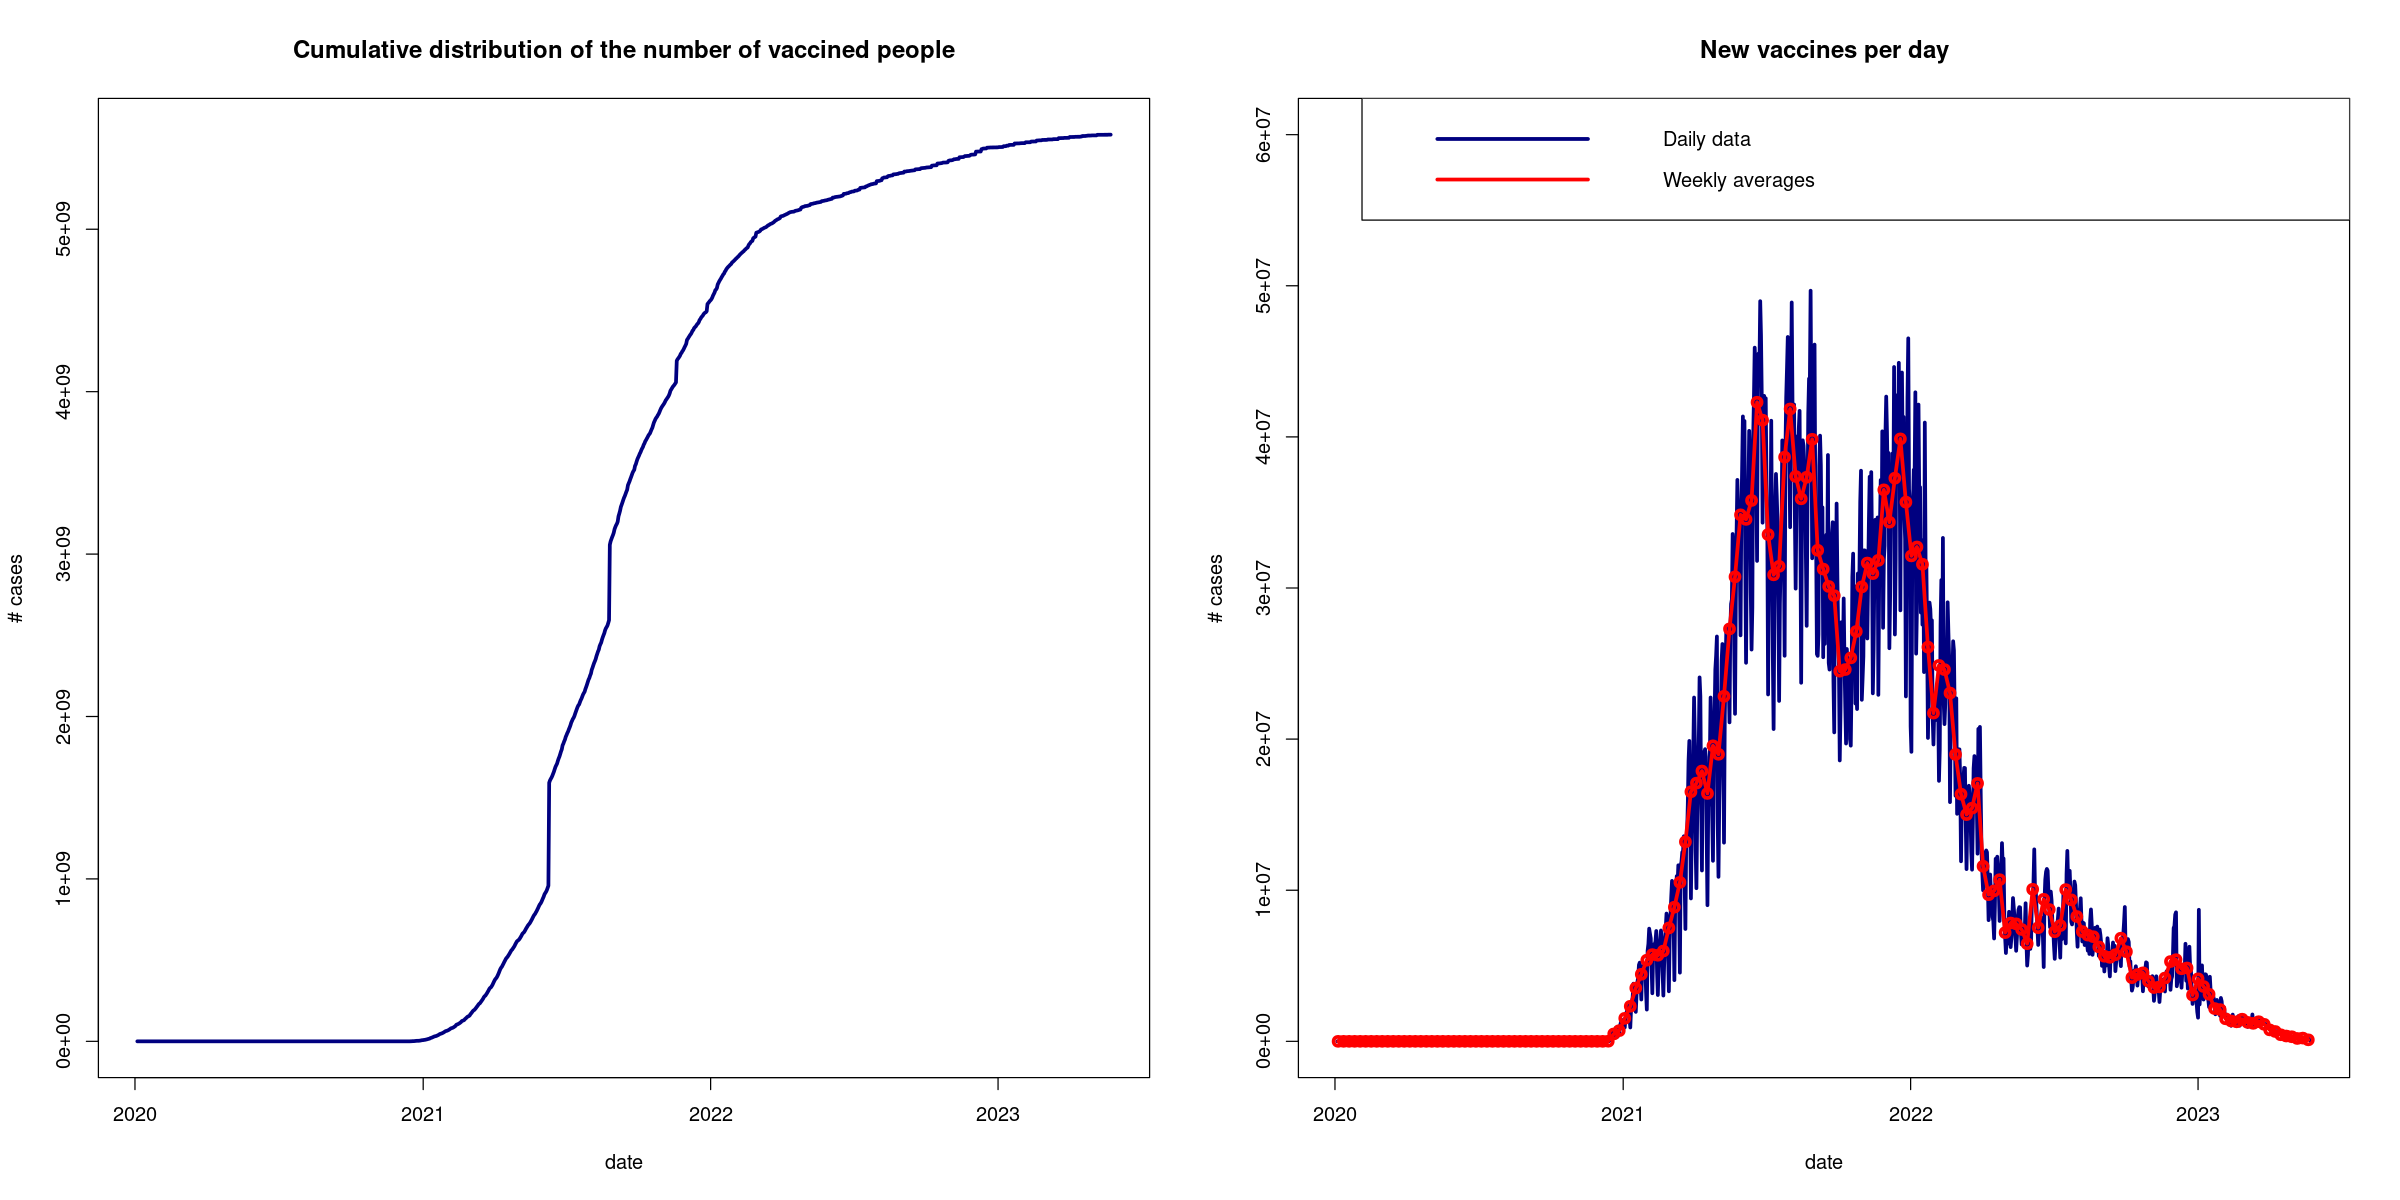

In [17]:
# And then I plot the behaviour of these two selections
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=10)

plot(world_data$date, cumulative_vaccines, type='l', lwd=3, col="navy", xlab="date", ylab="# cases", cex=1.5,
    main = paste("Cumulative distribution of the number of vaccined people"))
plot(world_data$date, daily_vaccines, type='l', lwd=3, col="navy", xlab="date", ylab="# cases", cex=1.5, main = paste("New vaccines per day"), ylim = c(0, 6e7))
lines(weekly_vaccines$cumulative_week, weekly_vaccines$total_per_week, type='o', lwd=3, col="red")
legend("topright", legend = c("Daily data", "Weekly averages"), col = c("navy", "red"), lty = c(1, 1), lwd = c(3, 3))


$\bold{b)}$ with a similar code I can count the number of deaths:

In [18]:
# I start again from the "world_data" dataframe

# I take the cumulative number of dead people after removing NAs
if (length(world_data[is.na(world_data$total_deaths), ]$total_deaths) > 0) {
    world_data[is.na(world_data$total_deaths), ]$total_deaths = 0}
cumulative_deaths = world_data$total_deaths

# Then the daily vaccined people are similarly retrieved
if (length(world_data[is.na(world_data$new_deaths), ]$new_deaths) > 0) {
    world_data[is.na(world_data$new_deaths), ]$new_deaths = 0}
daily_deaths = world_data$new_deaths

# For the weekly average I have to add a column
weekly_deaths = world_data %>% group_by(week, year) %>% summarise(total_per_week = mean(new_deaths))
weekly_deaths$cumulative_week = as.Date(paste(weekly_deaths$week, weekly_deaths$year, 'Sun'), '%U %Y %a')
weekly_deaths = weekly_deaths[order(weekly_deaths$cumulative_week),]


`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 368 in year 2020 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 366 in year 2021 is invalid”
Warning message in strptime(x, format, tz = "GMT"):
“(0-based) yday 365 in year 2022 is invalid”


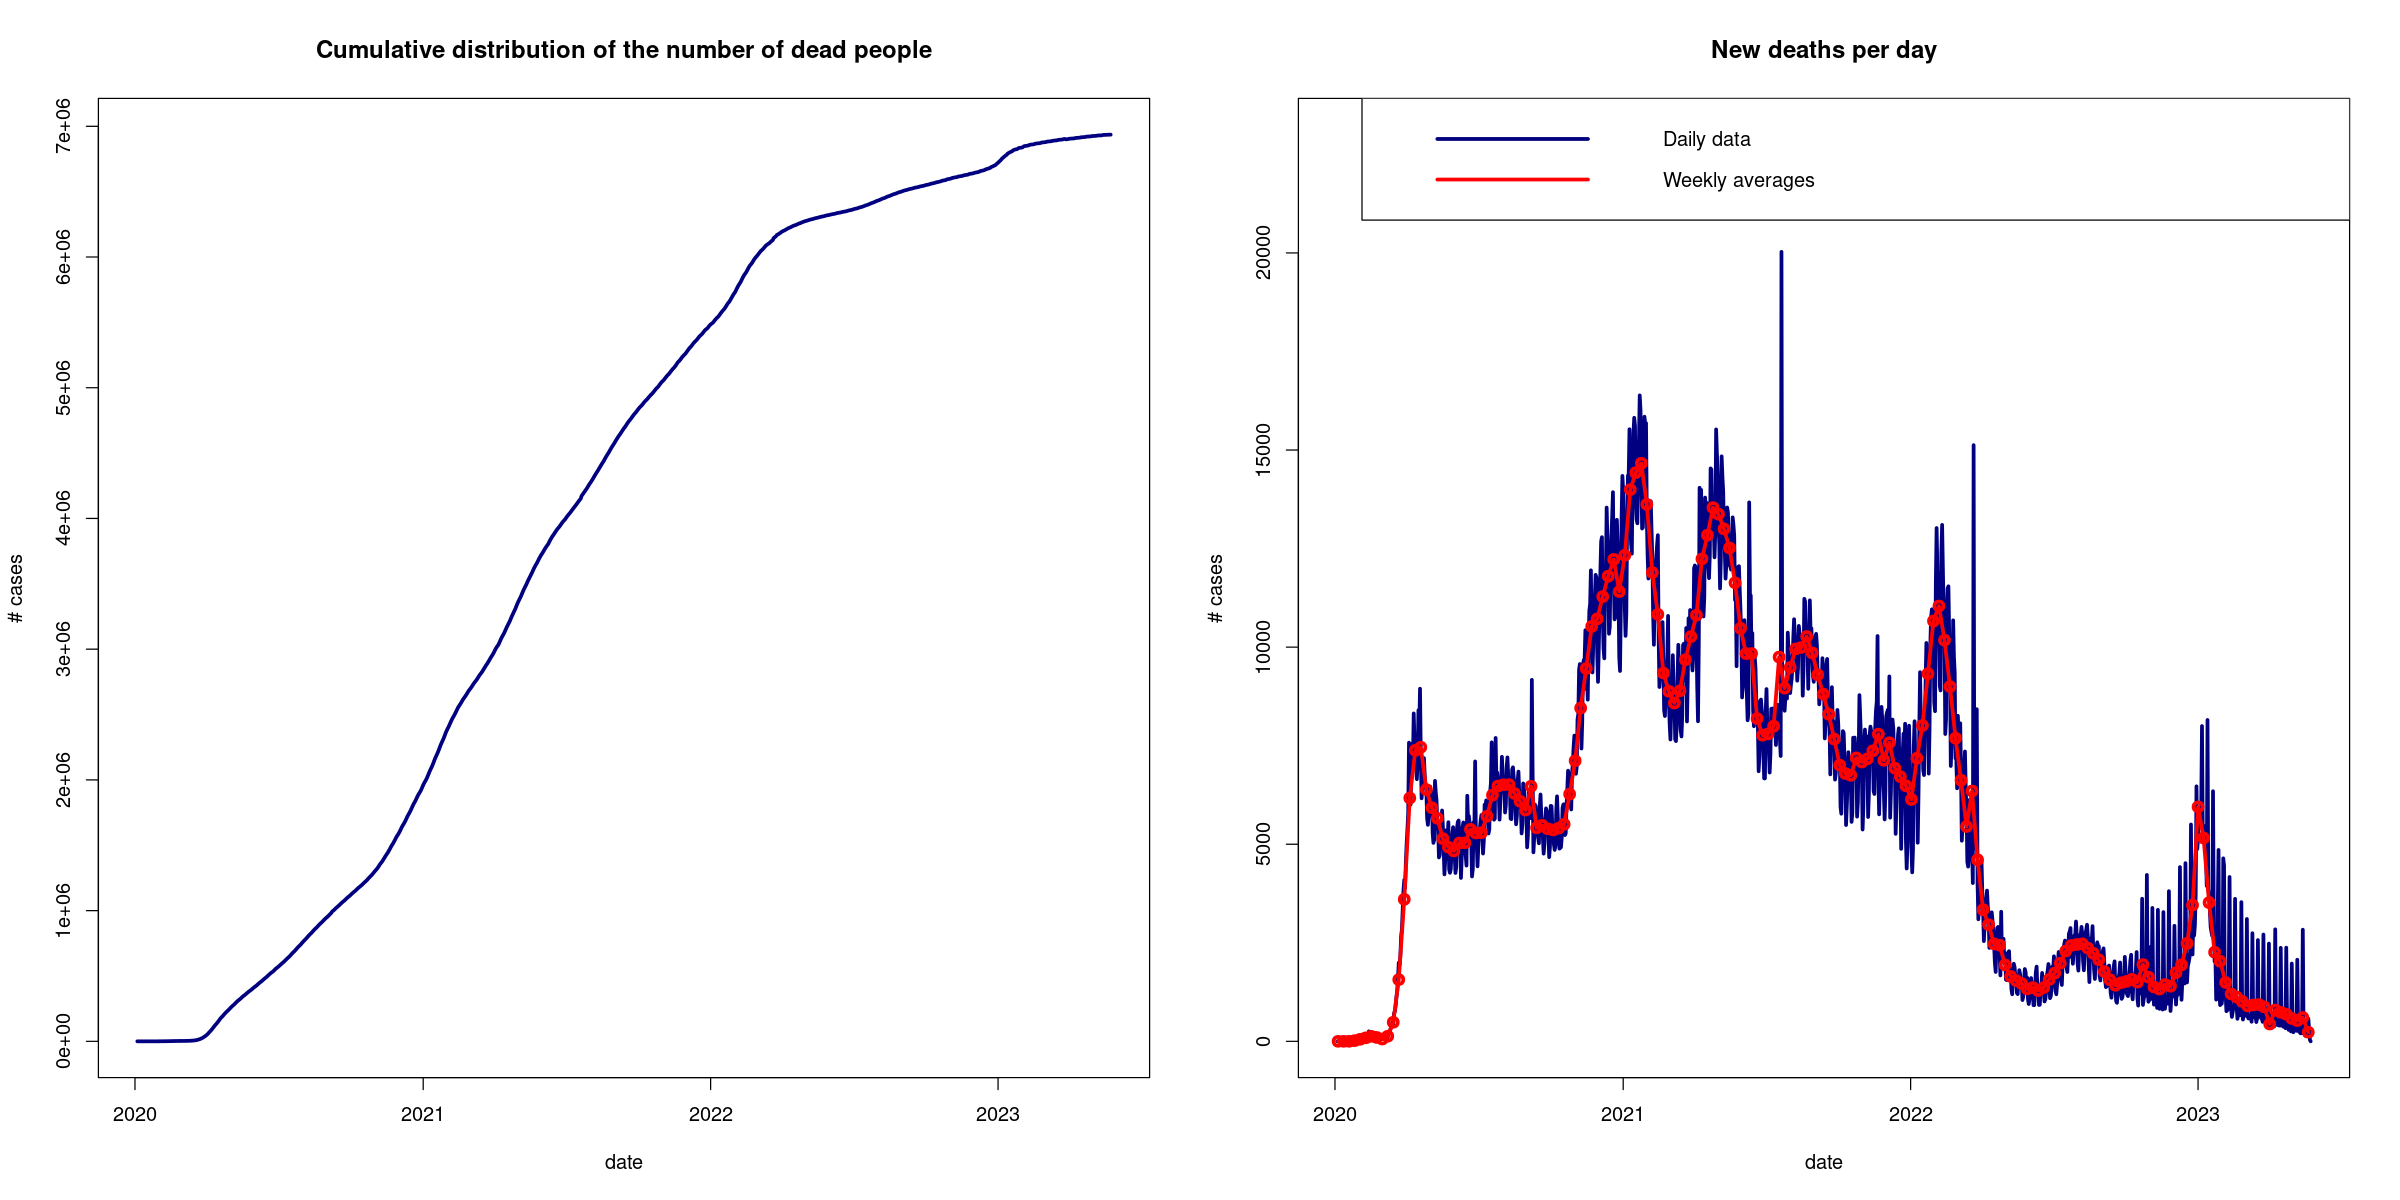

In [19]:
# And then I plot the behaviour of these two selections
par(mfrow=c(1,2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=10)

plot(world_data$date, cumulative_deaths, type='l', lwd=3, col="navy", xlab="date", ylab="# cases", cex=1.5,
    main = paste("Cumulative distribution of the number of dead people"))
plot(world_data$date, daily_deaths, type='l', lwd=3, col="navy", xlab="date", ylab="# cases", cex=1.5, main = paste("New deaths per day"), ylim = c(0, 2.3e4))
lines(weekly_deaths$cumulative_week, weekly_deaths$total_per_week, type='o', lwd=3, col="red")
legend("topright", legend = c("Daily data", "Weekly averages"), col = c("navy", "red"), lty = c(1, 1), lwd = c(3, 3))
